In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing All Libraries

In [2]:
import os
import re
import numpy as np
import pandas as pd
import string
import math,nltk
import seaborn as sns
import six
import pickle
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn
sklearn.__version__

'1.2.2'

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
import tensorflow
tensorflow.__version__

'2.15.0'

#Dataset Loading

In [6]:
resumedf=pd.read_csv("/content/drive/MyDrive/resume_classification/Data/UpdatedResumeDataSet.csv")
resumedf.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [7]:
resumedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


#Data Cleaning

In [8]:
resumedf.isna().sum()

Category    0
Resume      0
dtype: int64

In [9]:
resumedf.describe()

,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


#Data Analysis(EDA)

Text(0.5, 1.0, 'Resume distribution by Category types')

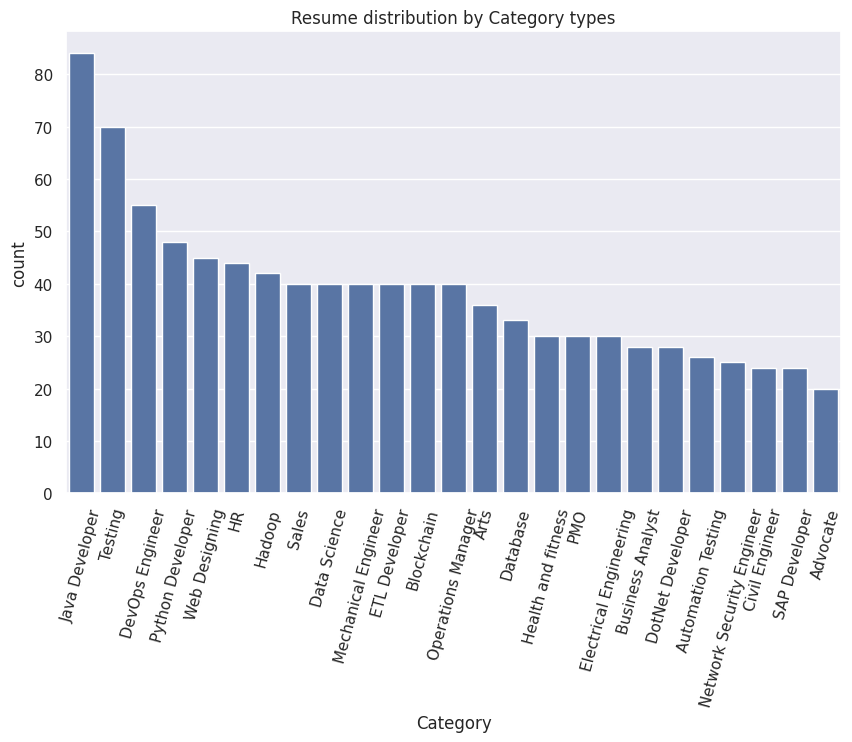

In [10]:
sns.set(rc={'figure.figsize':(10,6)})
plt.xticks(rotation=75)
sns.countplot(x="Category",orient="v", data=resumedf, order=resumedf.Category.value_counts().index).set_title("Resume distribution by Category types")

In [11]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
def display_word_cloud(field_name, title):
    words = resumedf[resumedf['Category'] == field_name].Resume
    cloud = WordCloud(background_color='black', width=1700, height=800, colormap="YlGnBu", collocations=False).generate(" ".join(words))
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.imshow(cloud)


In [12]:
resumedf['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

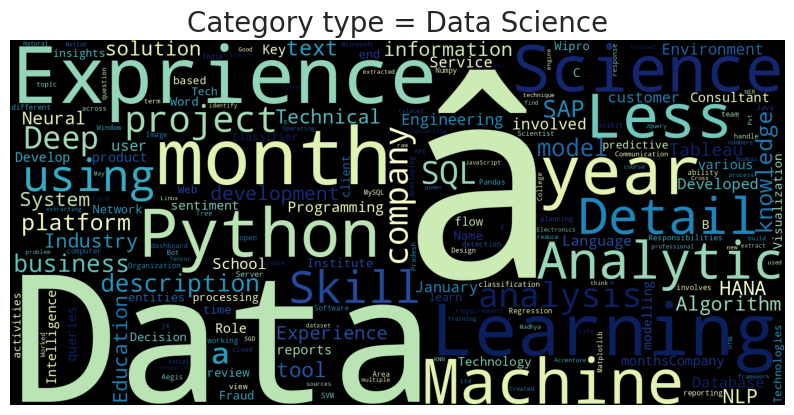

In [13]:
display_word_cloud('Data Science', 'Category type = Data Science')

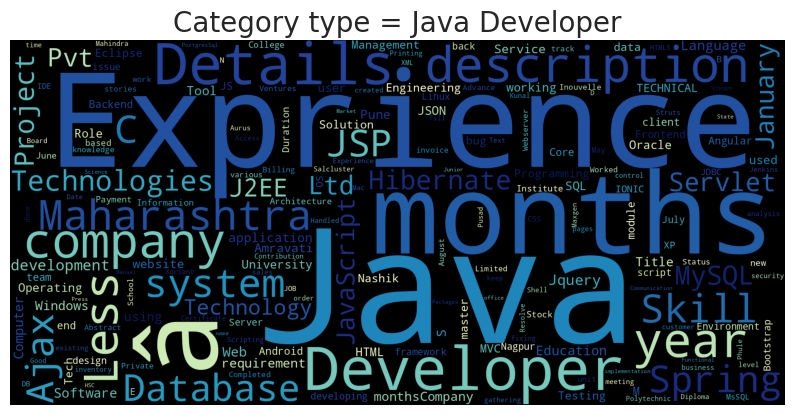

In [14]:
display_word_cloud('Java Developer', 'Category type = Java Developer')

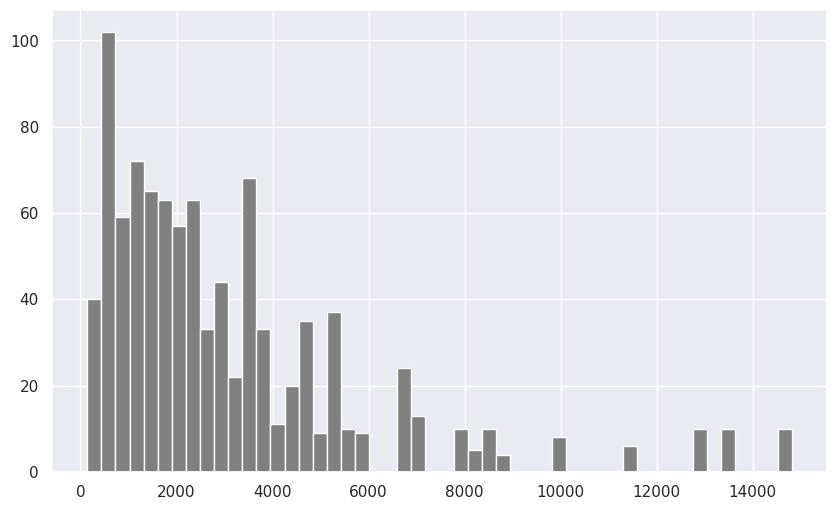

In [15]:
text_lengths = []
for dep_text in resumedf['Resume']:
  text_lengths.append(len(dep_text))
plt.hist(text_lengths, bins=50, color='gray')
plt.show()

#Text Cleaning

In [16]:
_wnl = nltk.WordNetLemmatizer()

def normalize_word(w):
    return _wnl.lemmatize(w).lower()

def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


In [17]:
def clean(text):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation),''))
    return " ".join(re.findall(r'\w+', text, flags=re.UNICODE)).lower()

def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]
def join_tok(text):
    return " ".join(text).lower()

In [18]:
def process(texts):
    lst=[]
    for text in tqdm(texts):
        clean_text= clean(text)
        tok_text= get_tokenized_lemmas(clean_text)
        remov_stp= remove_stopwords(tok_text)
        lst.append(join_tok(remov_stp))
    return lst

In [19]:
resumetxt =  process(resumedf['Resume'])
resumetxt[1]

100%|██████████| 962/962 [00:04<00:00, 197.84it/s]


'education 2013 2017 b e uit rgpv data scientist data scientist matelabs skill python exprience le 1 year month statsmodels exprience 12 month aws exprience le 1 year month machine learning exprience le 1 year month sklearn exprience le 1 year month scipy exprience le 1 year month kera exprience le 1 year monthscompany company matelabs description ml platform business professional dummy enthusiast 60 koramangala 5th block achievement task sukh sagar bengaluru india developed deployed auto preprocessing step machine learning mainly missing value treatment outlier detection encoding scaling feature selection dimensionality reduction deployed automated classification regression model linkedin com aditya rathore b4600b146 reasearch deployed time series forecasting model arima sarimax holt winter prophet worked meta feature extracting problem github com rathorology implemented state art research paper outlier detection mixed attribute company matelabs description'

#Text Preprocessing

In [20]:
Y= resumedf['Category']
tfidfvector = TfidfVectorizer(stop_words='english', max_features=300)
tfidf_values = tfidfvector.fit(resumetxt)
X= tfidfvector.transform(resumetxt).toarray()
print(X.shape)

(962, 300)


In [22]:
pickle.dump(tfidfvector,open('/content/drive/MyDrive/resume_classification/Model/tfidfvector.pkl', 'wb'))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.1, stratify=Y)

#Machine Learning

#Random Forest Classifier

In [24]:
rf = RandomForestClassifier(n_estimators=10, max_depth=6)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print ("Random Forest Classifier : Training Accuracy : ", rf.score(X_train,y_train)*100)
print ("Random Forest Classifier : Testing Accuracy : ", accuracy_score(y_test,y_pred)*100)

Random Forest Classifier : Training Accuracy :  91.21387283236994
Random Forest Classifier : Testing Accuracy :  85.56701030927834


<Axes: >

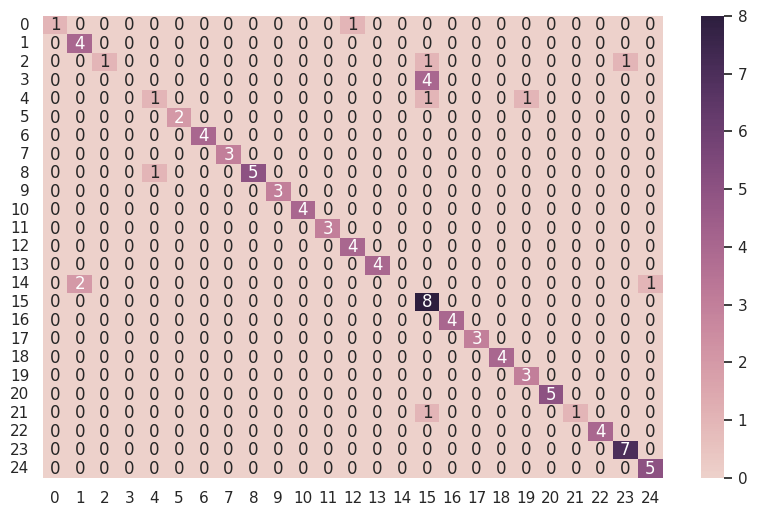

In [25]:
#confusion Matrix
matrix =confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap=sns.cubehelix_palette(as_cmap=True) ,fmt='g')

In [26]:
#classification report
print(classification_report(y_test,y_pred))

                           precision    recall  f1-score   support

                 Advocate       1.00      0.50      0.67         2
                     Arts       0.67      1.00      0.80         4
       Automation Testing       1.00      0.33      0.50         3
               Blockchain       0.00      0.00      0.00         4
         Business Analyst       0.50      0.33      0.40         3
           Civil Engineer       1.00      1.00      1.00         2
             Data Science       1.00      1.00      1.00         4
                 Database       1.00      1.00      1.00         3
          DevOps Engineer       1.00      0.83      0.91         6
         DotNet Developer       1.00      1.00      1.00         3
            ETL Developer       1.00      1.00      1.00         4
   Electrical Engineering       1.00      1.00      1.00         3
                       HR       0.80      1.00      0.89         4
                   Hadoop       1.00      1.00      1.00     

#GradientBoosting Classifier

In [27]:
gbc = GradientBoostingClassifier(max_depth=1, n_estimators=6)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print ("Gradient Boosting Classifier : Training Accuracy : ", gbc.score(X_train,y_train)*100)
print ("Gradient Boosting Classifier : Testing Accuracy : ", accuracy_score(y_test,y_pred)*100)

Gradient Boosting Classifier : Training Accuracy :  95.14450867052024
Gradient Boosting Classifier : Testing Accuracy :  88.65979381443299


<Axes: >

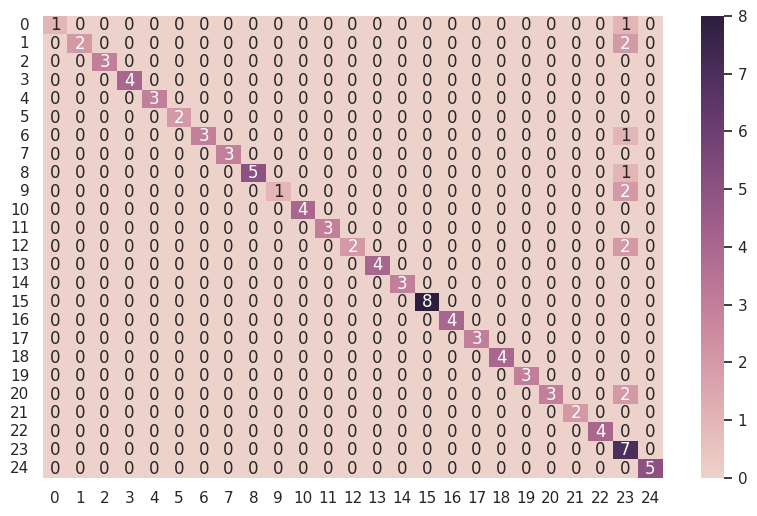

In [28]:
#confusion Matrix
matrix =confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap=sns.cubehelix_palette(as_cmap=True) ,fmt='g')

In [29]:
#classification report
print(classification_report(y_test,y_pred))

                           precision    recall  f1-score   support

                 Advocate       1.00      0.50      0.67         2
                     Arts       1.00      0.50      0.67         4
       Automation Testing       1.00      1.00      1.00         3
               Blockchain       1.00      1.00      1.00         4
         Business Analyst       1.00      1.00      1.00         3
           Civil Engineer       1.00      1.00      1.00         2
             Data Science       1.00      0.75      0.86         4
                 Database       1.00      1.00      1.00         3
          DevOps Engineer       1.00      0.83      0.91         6
         DotNet Developer       1.00      0.33      0.50         3
            ETL Developer       1.00      1.00      1.00         4
   Electrical Engineering       1.00      1.00      1.00         3
                       HR       1.00      0.50      0.67         4
                   Hadoop       1.00      1.00      1.00     

In [30]:
filename = '/content/drive/MyDrive/resume_classification/Model/gbcmodel.sav'
pickle.dump(gbc, open(filename, 'wb'))